### Due to computational limitations from google colab, we illustrate the training and testing of a network on CMC maps using a simplify version of the benchmark codes and also using a fraction of all the data available. We note that the results obtained in this example are far from optimal and are just shown as an illustration.

### Import libraries

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import r2_score
from tqdm import tqdm

from models import model_o3_err, model_o3_err_cosmology, model_o3_err_18layers
from dataloader import create_dataset_multifield

In [11]:
# import CKA package
# from similarity.CKA import CKA, CudaCKA
# from absl import flags
from similarity.efficient_CKA import *

2023-12-08 12:18:20.427041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 12:18:20.959831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### The code will run on both CPUs or GPUs

In [12]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


### Define the value of the parameters and hyperparameters

In [13]:
# data parameters
fmaps      = ['maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 15   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
# params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
params          = [0,1]
g               = params           #g will contain the mean of the posterior
# h               = [6+i for i in g] #h will contain the variance of the posterior
h               = [2+i for i in g]
rot_flip_in_mem = True             #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 128
min_lr     = 1e-9
max_lr     = 0.0036  # default: 1e-3
wd         = 0.0258  #value of weight decay, default: 0.0005
dr         = 0.4     #dropout value for fully connected layers, default: 0.2
hidden     = 11       #this determines the number of channels in the CNNs; integer larger than 1, default: 5
epochs     = 50      #number of epochs to train the network

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

In [6]:
# TNG - 43

# data
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
fmaps2 = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'
# fmaps2 = '2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy'

maps  = np.load(fmaps2)
np.save('maps_T_TNG.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


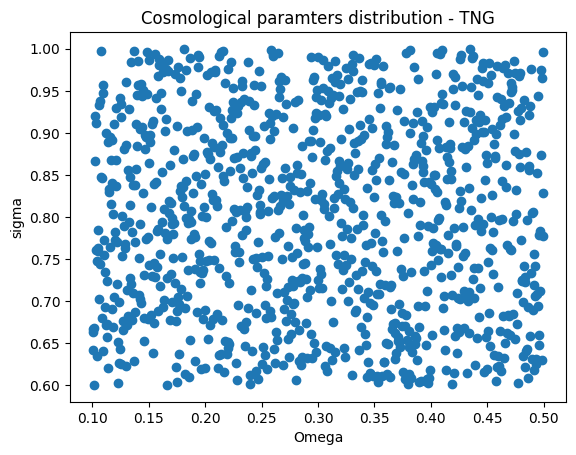

In [7]:
params_sims = np.loadtxt(fparams)
Omega = params_sims[:, 0]  # 0.1002 - 0.0004 - 0.4998, 1000
sigma = params_sims[:, 1]  # 0.6002 - 0.0004 - 0.9998, 1000
plt.scatter(Omega, sigma)
plt.xlabel('Omega')
plt.ylabel('sigma')
plt.title('Cosmological paramters distribution - TNG')
# plt.savefig('dist_TNG.png')
plt.show()

In [8]:
# SIMBA - 37

# data
fparams = '2D_maps/data/params_LH_SIMBA.txt'
fmaps2 = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'
# fmaps2 = '2D_maps/data/Maps_Mtot_SIMBA_LH_z=0.00.npy'

maps  = np.load(fmaps2)
np.save('maps_T_SIMBA.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


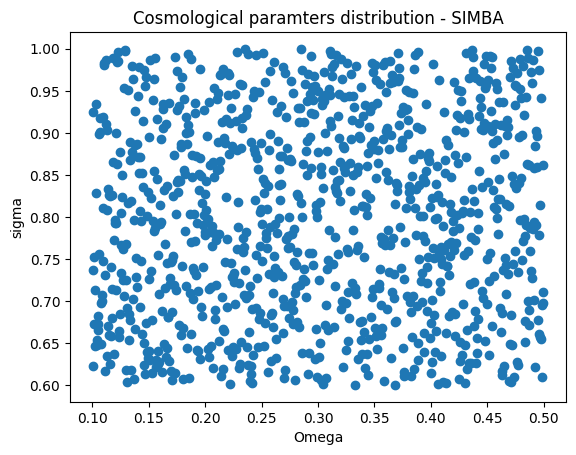

In [9]:
params_sims = np.loadtxt(fparams)
Omega = params_sims[:, 0]  # 0.1002 - 0.0004 - 0.4998, 1000
sigma = params_sims[:, 1]  # 0.6002 - 0.0004 - 0.9998, 1000
plt.scatter(Omega, sigma)
plt.xlabel('Omega')
plt.ylabel('sigma')
plt.title('Cosmological paramters distribution - SIMBA')
# plt.savefig('dist_SIMBA.png')
plt.show()

In [5]:
# TNG + SIMBA

# data
fmaps2_TNG = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'
fmaps2_SIMBA = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

fparams = '2D_maps/data/params_LH.txt'

# load data
maps_TNG = np.load(fmaps2_TNG)
maps_SIMBA = np.load(fmaps2_SIMBA)
maps = np.concatenate((maps_TNG, maps_SIMBA), axis=0)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (30000, 256, 256)


In [14]:
fmaps = ['maps_T_TNG.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
TNG_test_loader = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

TNG_maps = torch.zeros(0)
for x, y in TNG_test_loader:
    TNG_maps = torch.concat((TNG_maps, x.flatten()))

750
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550


In [15]:
# load test set
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_SIMBA.txt'
SIMBA_test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

SIMBA_maps = torch.zeros(0)
for x, y in SIMBA_test_loader:
    SIMBA_maps = torch.concat((SIMBA_maps, x.flatten()))

750
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815


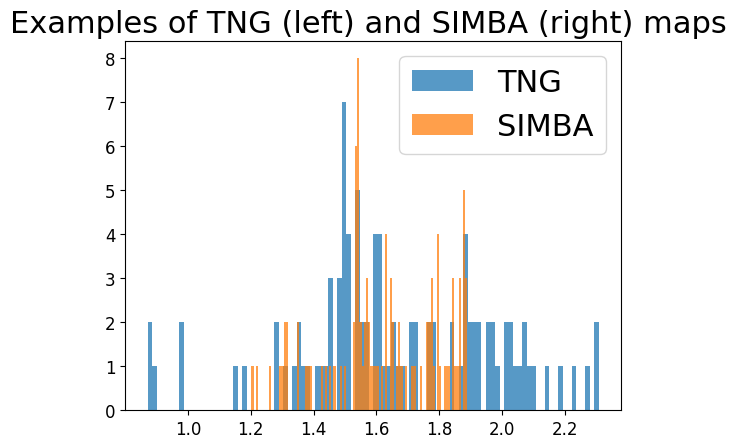

In [33]:
plt.hist(TNG_maps[:100], bins=100, label='TNG', alpha=0.75)
plt.hist(SIMBA_maps[:100], bins=100, label='SIMBA', alpha=0.75)
plt.legend(fontsize=22)
plt.title('Examples of TNG (left) and SIMBA (right) maps ', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('dist_maps.png')
plt.show()

In [11]:
# now that architecture is defined above, use it
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
# fmodel = 'layer17_TNG/weights.pt'
# fmodel = 'layer20_TNG_SIMBA/weights.pt'
fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

total number of parameters in the model = 28436376
Weights loaded


In [12]:
model

model_o3_err(
  (C01): Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C02): Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C03): Conv2d(22, 22, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B01): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B02): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B03): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C11): Conv2d(22, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C12): Conv2d(44, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C13): Conv2d(44, 44, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B11): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B12): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_runnin